In [132]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [133]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [134]:
NUM_CLASSES = 4

# Dataset reading

In [135]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [136]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [147]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [139]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_25 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_26 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 44        
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, save_best_only=True, monitor="val_accuracy", verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=40, verbose=1)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=20,
    verbose=1)

In [148]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [149]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, lr_reducer]
)

Epoch 1/1000
32/32 [==============================] - 1s 10ms/step - loss: 1.2863 - accuracy: 0.3588 - val_loss: 1.2014 - val_accuracy: 0.4880

Epoch 00001: val_accuracy did not improve from 0.97534
Epoch 2/1000
32/32 [==============================] - 0s 4ms/step - loss: 1.1710 - accuracy: 0.5238 - val_loss: 1.0981 - val_accuracy: 0.5949

Epoch 00002: val_accuracy did not improve from 0.97534
Epoch 3/1000
32/32 [==============================] - 0s 4ms/step - loss: 1.0613 - accuracy: 0.6105 - val_loss: 0.9778 - val_accuracy: 0.6689

Epoch 00003: val_accuracy did not improve from 0.97534
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.9324 - accuracy: 0.6683 - val_loss: 0.8393 - val_accuracy: 0.7272

Epoch 00004: val_accuracy did not improve from 0.97534
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.7993 - accuracy: 0.6925 - val_loss: 0.7150 - val_accuracy: 0.7399

Epoch 00005: val_accuracy did not improve from 0.97534
Epoch 6/1

In [150]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 3ms/step - loss: 0.0439 - accuracy: 0.9903


In [151]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [152]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[3.5804772e-09 4.5868000e-03 9.9541324e-01 7.3020107e-10]
2


# Confusion matrix

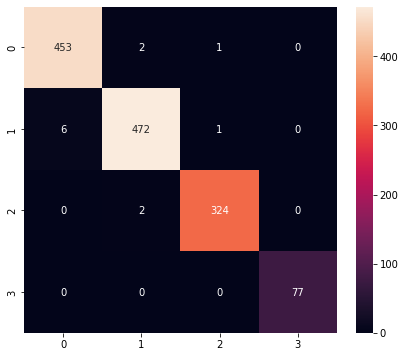

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       456
           1       0.99      0.99      0.99       479
           2       0.99      0.99      0.99       326
           3       1.00      1.00      1.00        77

    accuracy                           0.99      1338
   macro avg       0.99      0.99      0.99      1338
weighted avg       0.99      0.99      0.99      1338



In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [154]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [155]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpunfksmez/assets


INFO:tensorflow:Assets written to: /tmp/tmpunfksmez/assets
2021-10-28 11:38:52.001266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 11:38:52.001549: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-10-28 11:38:52.001627: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-10-28 11:38:52.001920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 11:38:52.002201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 11:38:52.002454: I t

6432

# Inference test

In [156]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [157]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [158]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [159]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 175 µs, sys: 18 µs, total: 193 µs
Wall time: 164 µs


In [160]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.5804635e-09 4.5867916e-03 9.9541324e-01 7.3020101e-10]
2
